<img src="../docs/figure/icon.png" alt="Icon" width="1200">

## Introduction <a id='1'></a>

### Project Aim <a id="1-1"></a>

The aim of project is to create a model that estimates the time taken for a delivery. Concretely, for a given delivery you must predict the total delivery duration seconds, i.e. the time taken from <br>
* Start: the time consumer submits the order (created at) to
* End: when the order will be delivered to the consumer(actual delivery time)

### Dataset Overview <a id="1-2"></a>

<b> Data Sources: </b>The dataset for this project is from  <a href="https://platform.stratascratch.com/data-projects/delivery-duration-prediction" target="_blank">StrataScratch</a> 


<b> Time Features </b><br>
* `created_at (object)`: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
* `actual_delivery_time (object)`: Timestamp in UTC when the order was delivered to the consumer

<b> Store Features </b><br>
* `store_id (int)`: an id representing the restaurant the order was submitted for
* `store_primary_category (object)`: cuisine category of the restaurant, e.g., italian, asian
* `order_protocol (float)`: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

<b> Order Features </b><br>
* `total_items (int)`: total number of items in the order
* `subtotal (int)`: total value of the order submitted (in cents)
* `num_distinct_items (int)`: number of distinct items included in the order
* `min_item_price (int)`: price of the item with the least cost in the order (in cents)
* `max_item_price (int)`: price of the item with the highest cost in the order (in cents)

<b> Market Features </b><br>
* `market_id (float)`: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
* `total_onshift_dashers (float)`: Number of available dashers who are within 10 miles of the store at the time of order creation
* `total_busy_dashers (float)`: Subset of above __total_onshift_dashers__ who are currently working on an order
* `total_outstanding_orders (float)`: Number of orders within 10 miles of this order that are currently being processed

<b> Predictions From Other Models </b><br>
* `estimated_order_place_duration (int)`: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
* `estimated_store_to_consumer_driving_duration (float)`: Estimated travel time between store and consumer (in seconds)

## Table of Contents
- [Introduction](#1)
    - [Project Aim](#1-1)
    - [Dataset Overview](#1-2)
- [Library Imports](#2)
- [Data Understanding and Initial Cleaning](#3)
    - [Handle Missing Values](#3-1)
- [Exploratory Data Analysis](#4)
    - [Outlier Analysis](#4-1)
- [Feature Engineering](#5)
    - [Create New Features](#5-1)
    - [Encode Categorical Features](#5-2)
    - [Collinearity and Removing Redundancies](#5-3)
    - [Multicollinearity and Feature Selection](#5-4)
- [Build Machine Learning Models](#6)

## Library Imports <a id='2'></a>

In [ ]:
import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

project_path = os.path.abspath(os.path.join(".."))
sys.path.append(project_path)
from src.utils import create_dummies, correlation_heatmap, get_top_abs_correlations, compute_vif, visualize_outlier, plot_regression, \
                      plot_gini_importance, scale, create_regression

# from src.visualization_utils import *
# from src.data_processing_utils import *
# from src.analysis_utils import *
# from src.model_utils import create_regression

## Data Understanding and Initial Cleaning <a id='3'></a>

In [2]:
# load dataset
df = pd.read_csv('../data/raw/historical_data.csv')
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
# check duplicates
df.duplicated().any(axis=0)

np.False_

### Handle Missing Values <a id="3-1"></a>

In [5]:
display(df.isna().sum())

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

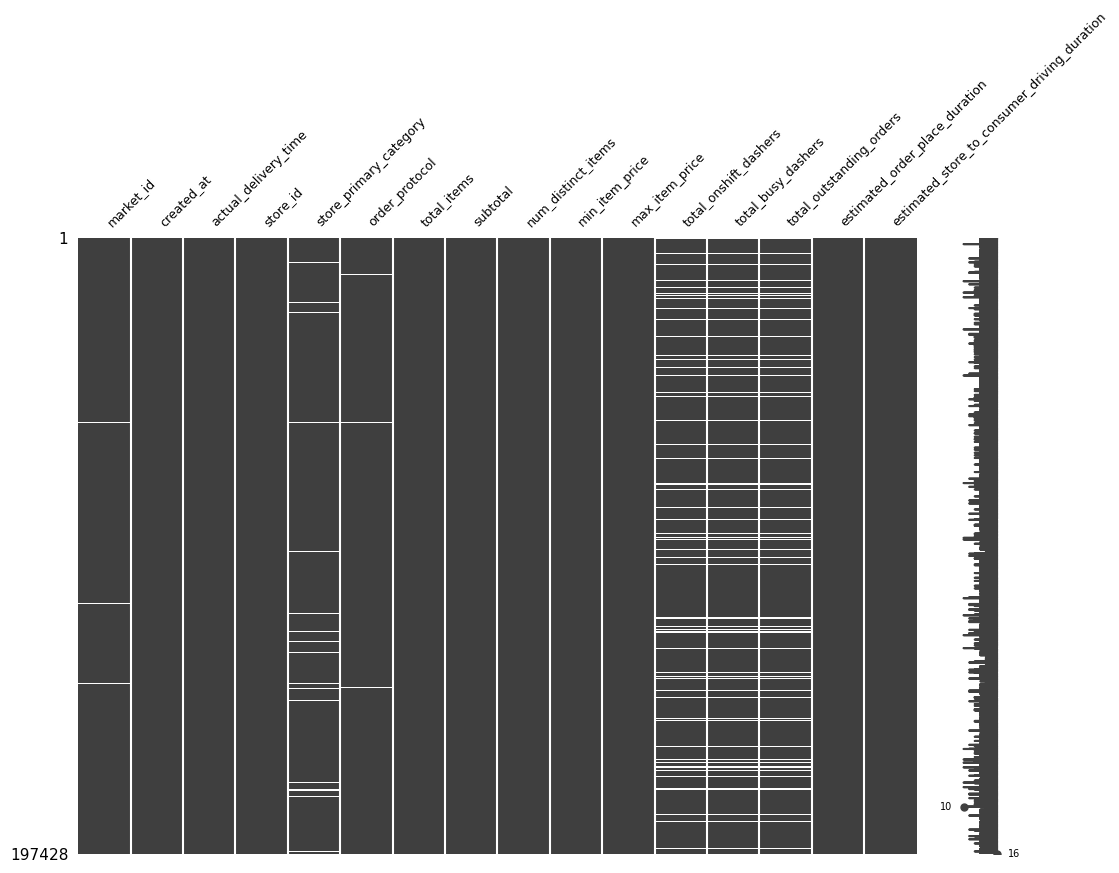

In [6]:
msno.matrix(df,figsize=(12, 8),fontsize=9,color=(0.25, 0.25, 0.25));

In [7]:
print(f"%{(len(df[df.isna().any(axis=1)]) / len(df)) * 100}")

%10.96652957027372


* The percantage of rows with null data is about %11 and about %9 of this comes from 3 different features. So let's remove all null data from dataset.

In [8]:
df = df.dropna()
df = df.reset_index(drop=True)
df.isna().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
dtype: int64

## Exploratory Data Analysis <a id='4'></a>

* Before we examine the summary of the dataset, let's calculate the total delivery time for each row. To do this, we first need to convert the data type of the `created_at` and `actual_delivery_time` features. Then, create a new feature called total delivery duration (target variable).

In [9]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['total_delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0
4,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0


In [10]:
numeric_columns = ['total_items', 'subtotal','num_distinct_items', 'min_item_price','max_item_price', 'total_onshift_dashers',
                   'total_busy_dashers', 'total_outstanding_orders','estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
                   'total_delivery_duration']
df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
total_items,175777.0,3.204976,2.674055,1.0,2.0,3.0,4.0,411.0
subtotal,175777.0,2697.111147,1828.554893,0.0,1412.0,2224.0,3410.0,26800.0
num_distinct_items,175777.0,2.675060,1.625681,1.0,1.0,2.0,3.0,20.0
min_item_price,175777.0,684.965433,519.882924,-86.0,299.0,595.0,942.0,14700.0
max_item_price,175777.0,1160.158616,560.828571,0.0,799.0,1095.0,1395.0,14700.0
total_onshift_dashers,175777.0,44.918664,34.544724,-4.0,17.0,37.0,66.0,171.0
total_busy_dashers,175777.0,41.861381,32.168505,-5.0,15.0,35.0,63.0,154.0
total_outstanding_orders,175777.0,58.230115,52.731043,-6.0,17.0,41.0,85.0,285.0
estimated_order_place_duration,175777.0,307.818105,89.796587,0.0,251.0,251.0,446.0,2715.0
estimated_store_to_consumer_driving_duration,175777.0,546.077240,218.717798,0.0,384.0,544.0,703.0,2088.0


* The minimum values of `min_item_price`, `total_onshift_dashers`, `total_busy_dashers` and `total_outstanding_orders` cannot be below 0. Let's observe these variables in the dataset.

In [11]:
desired_df = df.query((
    'min_item_price < 0 or '
    'total_onshift_dashers < 0 or '
    'total_busy_dashers < 0 or '
    'total_outstanding_orders < 0'
))
display(desired_df.head()), display(desired_df.shape);

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration
711,1.0,2015-01-29 02:59:28,2015-01-29 03:44:09,132,fast,4.0,3,1003,3,-86,1066,24.0,29.0,38.0,251,721.0,2681.0
1242,2.0,2015-02-06 05:26:55,2015-02-06 06:15:41,6740,fast,4.0,35,1786,4,-1,488,33.0,36.0,52.0,251,587.0,2926.0
4599,1.0,2015-02-18 00:36:21,2015-02-18 01:12:28,1811,smoothie,2.0,2,1940,1,840,856,11.0,14.0,-2.0,251,460.0,2167.0
5535,3.0,2015-02-14 01:48:58,2015-02-14 03:00:13,90,american,1.0,2,3538,2,1238,1606,-2.0,2.0,10.0,446,266.0,4275.0
7133,1.0,2015-02-08 15:41:45,2015-02-08 16:35:01,6172,sandwich,3.0,1,1514,1,1116,1063,1.0,-1.0,3.0,251,650.0,3196.0


(90, 17)

In [12]:
# remove these rows from the main dataset
df = df[~df.isin(desired_df)].dropna()
df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175687 entries, 0 to 175776
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     175687 non-null  float64       
 1   created_at                                    175687 non-null  datetime64[ns]
 2   actual_delivery_time                          175687 non-null  datetime64[ns]
 3   store_id                                      175687 non-null  float64       
 4   store_primary_category                        175687 non-null  object        
 5   order_protocol                                175687 non-null  float64       
 6   total_items                                   175687 non-null  float64       
 7   subtotal                                      175687 non-null  float64       
 8   num_distinct_items                            175687 non-nu

* Additionally, it is observed that the minimum value of `total items` is 1, but the minimum value of `subtotal` is 0. Let's check the rows where the `subtotal` value is equal to 0 and the `min_item_price` or `max_item_price` values ​​are greater than 0, or the `subtotal` value is greater than 0 and the `min_item_price` and `max_item_price` values ​​are equal to 0.

In [13]:
desired_df = df.query((
    'subtotal == 0 and (min_item_price > 0 or max_item_price > 0) or '
    'subtotal > 0 and (min_item_price ==0 and max_item_price == 0)'
))
display(desired_df.head()), display(desired_df.shape);

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration
988,4.0,2015-01-25 17:28:32,2015-01-25 18:03:00,517.0,american,3.0,7.0,0.0,7.0,295.0,1225.0,6.0,22.0,8.0,251.0,241.0,2068.0
1694,2.0,2015-02-07 17:25:00,2015-02-07 17:55:00,6740.0,fast,4.0,5.0,0.0,2.0,169.0,200.0,19.0,13.0,13.0,251.0,512.0,1800.0
3652,1.0,2015-01-31 01:42:46,2015-01-31 02:06:18,414.0,japanese,3.0,2.0,0.0,2.0,405.0,1395.0,16.0,16.0,16.0,251.0,200.0,1412.0
3909,1.0,2015-02-12 19:15:20,2015-02-12 19:49:09,490.0,breakfast,3.0,1.0,0.0,1.0,1495.0,1495.0,16.0,16.0,20.0,251.0,556.0,2029.0
6617,4.0,2015-01-25 02:09:31,2015-01-25 03:21:28,703.0,greek,2.0,2.0,0.0,2.0,1799.0,2599.0,61.0,80.0,103.0,251.0,139.0,4317.0


(168, 17)

In [14]:
# remove these rows from the main dataset
df = df[~df.isin(desired_df)].dropna()
df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175519 entries, 0 to 175776
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     175519 non-null  float64       
 1   created_at                                    175519 non-null  datetime64[ns]
 2   actual_delivery_time                          175519 non-null  datetime64[ns]
 3   store_id                                      175519 non-null  float64       
 4   store_primary_category                        175519 non-null  object        
 5   order_protocol                                175519 non-null  float64       
 6   total_items                                   175519 non-null  float64       
 7   subtotal                                      175519 non-null  float64       
 8   num_distinct_items                            175519 non-nu

### Outlier Analysis <a id="4-1"></a>

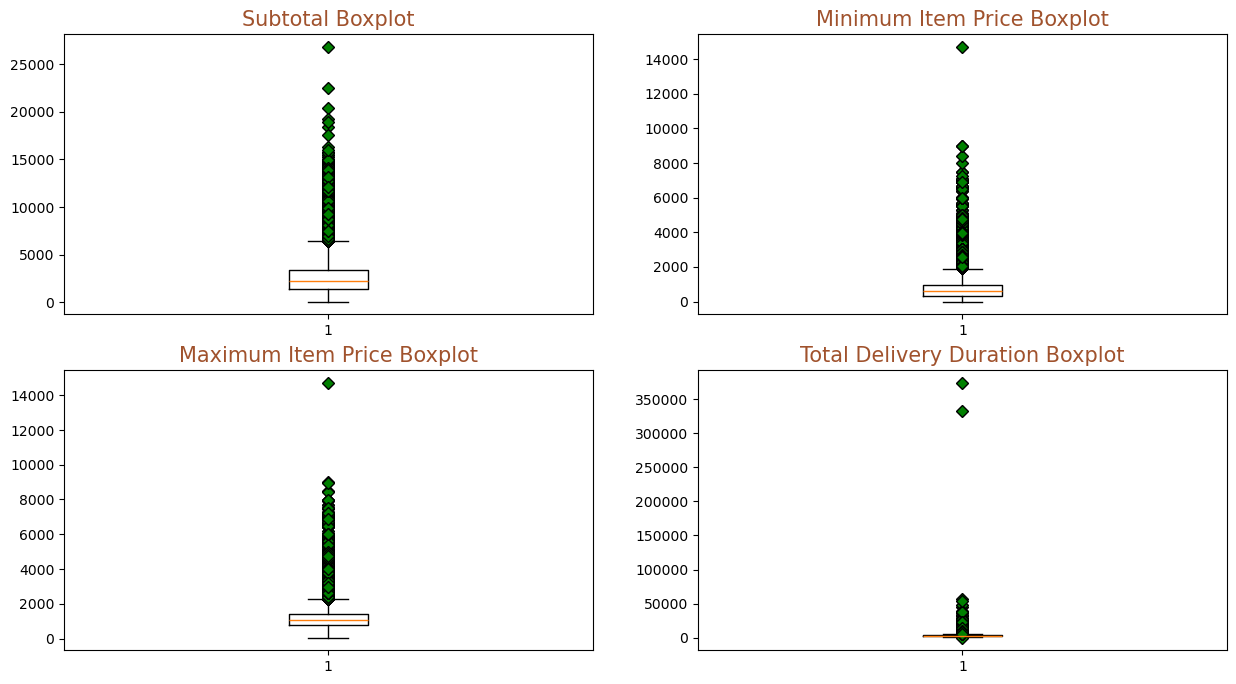

In [15]:
visualize_outlier(df)

* According to the box plot, there are some outliers in some features. For now, I will delete 2 values ​​in the target variables.

In [16]:
df = df[~df.isin(df.query('total_delivery_duration > 100000 or total_items > 400'))].dropna()
df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175516 entries, 0 to 175776
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     175516 non-null  float64       
 1   created_at                                    175516 non-null  datetime64[ns]
 2   actual_delivery_time                          175516 non-null  datetime64[ns]
 3   store_id                                      175516 non-null  float64       
 4   store_primary_category                        175516 non-null  object        
 5   order_protocol                                175516 non-null  float64       
 6   total_items                                   175516 non-null  float64       
 7   subtotal                                      175516 non-null  float64       
 8   num_distinct_items                            175516 non-nu

In [17]:
df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
total_items,175516.0,3.202323,2.488988,1.0,2.0,3.0,4.0,66.0
subtotal,175516.0,2699.718971,1827.695100,95.0,1418.0,2225.0,3414.0,26800.0
num_distinct_items,175516.0,2.675186,1.625713,1.0,1.0,2.0,3.0,20.0
min_item_price,175516.0,684.934912,519.801241,0.0,299.0,595.0,942.0,14700.0
max_item_price,175516.0,1160.218390,560.767662,60.0,799.0,1095.0,1395.0,14700.0
total_onshift_dashers,175516.0,44.940461,34.544541,0.0,17.0,37.0,66.0,171.0
total_busy_dashers,175516.0,41.881111,32.166309,0.0,15.0,35.0,63.0,154.0
total_outstanding_orders,175516.0,58.262016,52.735471,0.0,17.0,41.0,85.0,285.0
estimated_order_place_duration,175516.0,307.783718,89.782758,0.0,251.0,251.0,446.0,2715.0
estimated_store_to_consumer_driving_duration,175516.0,546.068569,218.720027,0.0,383.0,544.0,703.0,2088.0


### Check the Relationship Between Target and Features <a id="4-2"></a>

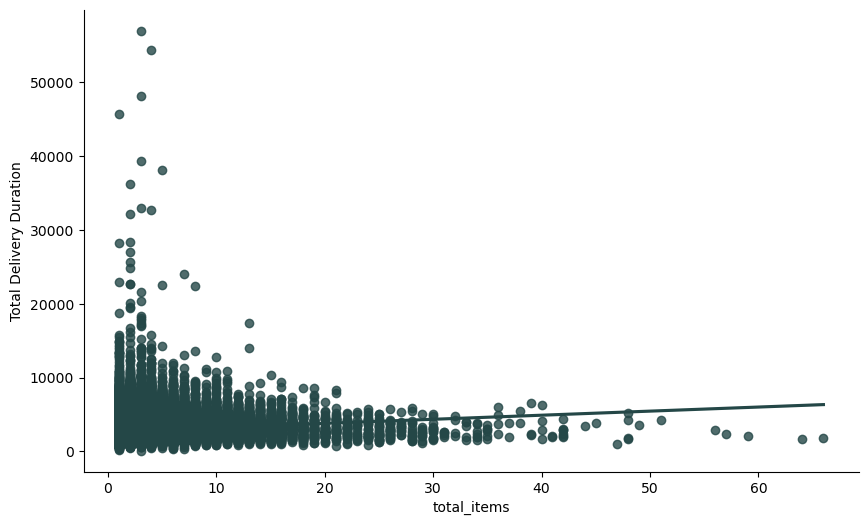

In [18]:
plot_regression(df)

Let's examine the relationship between `total_delivery_duration` and `total_items` variables according to the R-squared value.

In [19]:
x_items = sm.add_constant(df[["total_items"]])
y_delivery_duration = df['total_delivery_duration']

modelAC = sm.OLS(y_delivery_duration, x_items)
modelFitAC = modelAC.fit()
modelFitAC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     total_delivery_duration   R-squared:                       0.014
Model:                                 OLS   Adj. R-squared:                  0.014
Method:                      Least Squares   F-statistic:                     2482.
Date:                     Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                             00:40:11   Log-Likelihood:            -1.4870e+06
No. Observations:                   175516   AIC:                         2.974e+06
Df Residuals:                       175514   BIC:                         2.974e+06
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2685.3465      4.500    596.767      0.000    2676.527    2694.166
total_items    55.2729      1.109     49.819      0.000      53.098      57.447
==============================================================================
Omnibus:                   183962.649   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         92819187.329
Skew:                           4.546   Prob(JB):                         0.00
Kurtosis:                     115.292   Cond. No.                         6.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* The Total Item variable can explain approximately 1% of the variability in the Total Delivery Duration variable.

* Let's check if there is any relationship between `store_primary_category` and `total_delivery_duration`. To do this, let's create a hypothesis and then test it with ANOVA!

    - **H₀ (Null Hypothesis)**: The `store_primary_category` and `total_delivery_duration` are not related (the mean delivery durations are the same across all categories)
    - **H₁ (Alternative Hypothesis)**: The `store_primary_category` and `total_delivery_duration` are related (the mean delivery durations differ across categories, p-value < 0.05)

In [20]:
category_group_list = df.groupby('store_primary_category')['total_delivery_duration'].apply(list)
anova_result = f_oneway(*category_group_list)
float(anova_result[1])

0.0

Since the <b>p-value < 0.05</b>, we <b>reject the null hypothesis (H₀)</b>. Therefore, we conclude that there is a significant relationship between the `store_primary_category` and `total_delivery_duration`. The mean delivery durations differ across the categories.

## Feature Engineering <a id='5'></a>

In this step, we will first create new features, then encode categorical variables. Next, we will check the correlation among features and remove any redundant ones, followed by examining multicollinearity, and finally proceed with feature selection.

### Create New Features <a id="5-1"></a>

* Let's create a few features like `estimated_non_prep_duration`, `busy_dashers_ratio`. For `busy_dashers_ratio` we need to divide `total_busy_dashers` by `total_onshift_dashers`. However, some values ​​of `total_onshift_dashers` are equal to 0. So first remove these rows from the dataset.

In [21]:
df = df[~df.isin(df.query('total_onshift_dashers == 0'))].dropna()
df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171984 entries, 0 to 175776
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     171984 non-null  float64       
 1   created_at                                    171984 non-null  datetime64[ns]
 2   actual_delivery_time                          171984 non-null  datetime64[ns]
 3   store_id                                      171984 non-null  float64       
 4   store_primary_category                        171984 non-null  object        
 5   order_protocol                                171984 non-null  float64       
 6   total_items                                   171984 non-null  float64       
 7   subtotal                                      171984 non-null  float64       
 8   num_distinct_items                            171984 non-nu

In [22]:
df['busy_dashers_ratio'] = df['total_busy_dashers'] / df['total_onshift_dashers']
df['estimated_non_prep_duration'] = df['estimated_store_to_consumer_driving_duration'] + df['estimated_order_place_duration']
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845.0,american,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,3779.0,0.424242,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477.0,mexican,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,4024.0,2.000000,1136.0
2,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477.0,indian,3.0,4.0,4771.0,3.0,820.0,1604.0,8.0,6.0,18.0,446.0,289.0,1586.0,0.750000,735.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841.0,italian,1.0,1.0,1525.0,1.0,1525.0,1525.0,5.0,6.0,8.0,446.0,795.0,2273.0,1.200000,1241.0
4,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841.0,italian,1.0,2.0,3620.0,2.0,1425.0,2195.0,5.0,5.0,7.0,446.0,205.0,2988.0,1.000000,651.0


### Encode Categorical Features <a id="5-2"></a>

* Let's check the unique values of categorical features(market_id, store_id, order_protocol) and then encode them.

In [23]:
print(f"""unique market_id: {df["market_id"].nunique()}
unique store_id: {df["store_id"].nunique()}
unique order_protocol: {df["order_protocol"].nunique()}""")

unique market_id: 6
unique store_id: 5459
unique order_protocol: 7


* `market_id` and `order_protocol` can be encoded due to the amount of unique values, but it would be inconvenient to encode `store_id` directly because after the encoding process, the feature will be created as much as the unique value of the feature, which may create an overfitting problem as well as reducing the model training performance.
<a href="https://www.datacamp.com/tutorial/one-hot-encoding-python-tutorial?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=157098104375&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=684592139906&utm_targetid=aud-1645446892440:dsa-2264919291989&utm_loc_interest_ms=&utm_loc_physical_ms=1011347&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p1_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na-oct24&gad_source=1&gclid=Cj0KCQjwvpy5BhDTARIsAHSilylgixtgL4ThNm06eqr-9Z7WkTMPWYCEY8kLMEr350DHQyq7Z2r5tf4aArqnEALw_wcB" target="_blank">[1]</a>
<a href="https://www.deepchecks.com/glossary/one-hot-encoding/#:~:text=Because%20this%20procedure%20generates%20several,variables%2C%20lowering%20the%20model's%20accuracy." target="_blank">[2]</a>
Therefore, we will code the `store_primary_category` feature instead of `market_id`.

In [24]:
# code the desired categorical features
market_id_dummies = create_dummies(df, 'market_id')
order_protocol_dummies = create_dummies(df, 'order_protocol')
store_primary_category_dummies = create_dummies(df, 'store_primary_category')

* Now, let's delete unnecessary columns from the dataframe then concat all dataframes.

In [25]:
df = df.drop(columns= ['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time','order_protocol'])
df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,3779.0,0.424242,1307.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,4024.0,2.000000,1136.0
2,4.0,4771.0,3.0,820.0,1604.0,8.0,6.0,18.0,446.0,289.0,1586.0,0.750000,735.0
3,1.0,1525.0,1.0,1525.0,1525.0,5.0,6.0,8.0,446.0,795.0,2273.0,1.200000,1241.0
4,2.0,3620.0,2.0,1425.0,2195.0,5.0,5.0,7.0,446.0,205.0,2988.0,1.000000,651.0


In [26]:
train_df = pd.concat([df, market_id_dummies, order_protocol_dummies, store_primary_category_dummies], axis=1)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,cuisine_category_southern,cuisine_category_spanish,cuisine_category_steak,cuisine_category_sushi,cuisine_category_tapas,cuisine_category_thai,cuisine_category_turkish,cuisine_category_vegan,cuisine_category_vegetarian,cuisine_category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0,0,0,0,0,0,0,0,0,0
2,4.0,4771.0,3.0,820.0,1604.0,8.0,6.0,18.0,446.0,289.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1525.0,1.0,1525.0,1525.0,5.0,6.0,8.0,446.0,795.0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,3620.0,2.0,1425.0,2195.0,5.0,5.0,7.0,446.0,205.0,...,0,0,0,0,0,0,0,0,0,0


* Convert the data type of features to float (32) for machine learning models and for analyses

In [27]:
train_df = train_df.astype('float32')
# train_df.to_csv('../data/processed/df_before_feature_eng.csv', index=False)

### Collinearity and Removing Redundancies <a id="5-3"></a>

* Let's check correlation heatmap of dataset

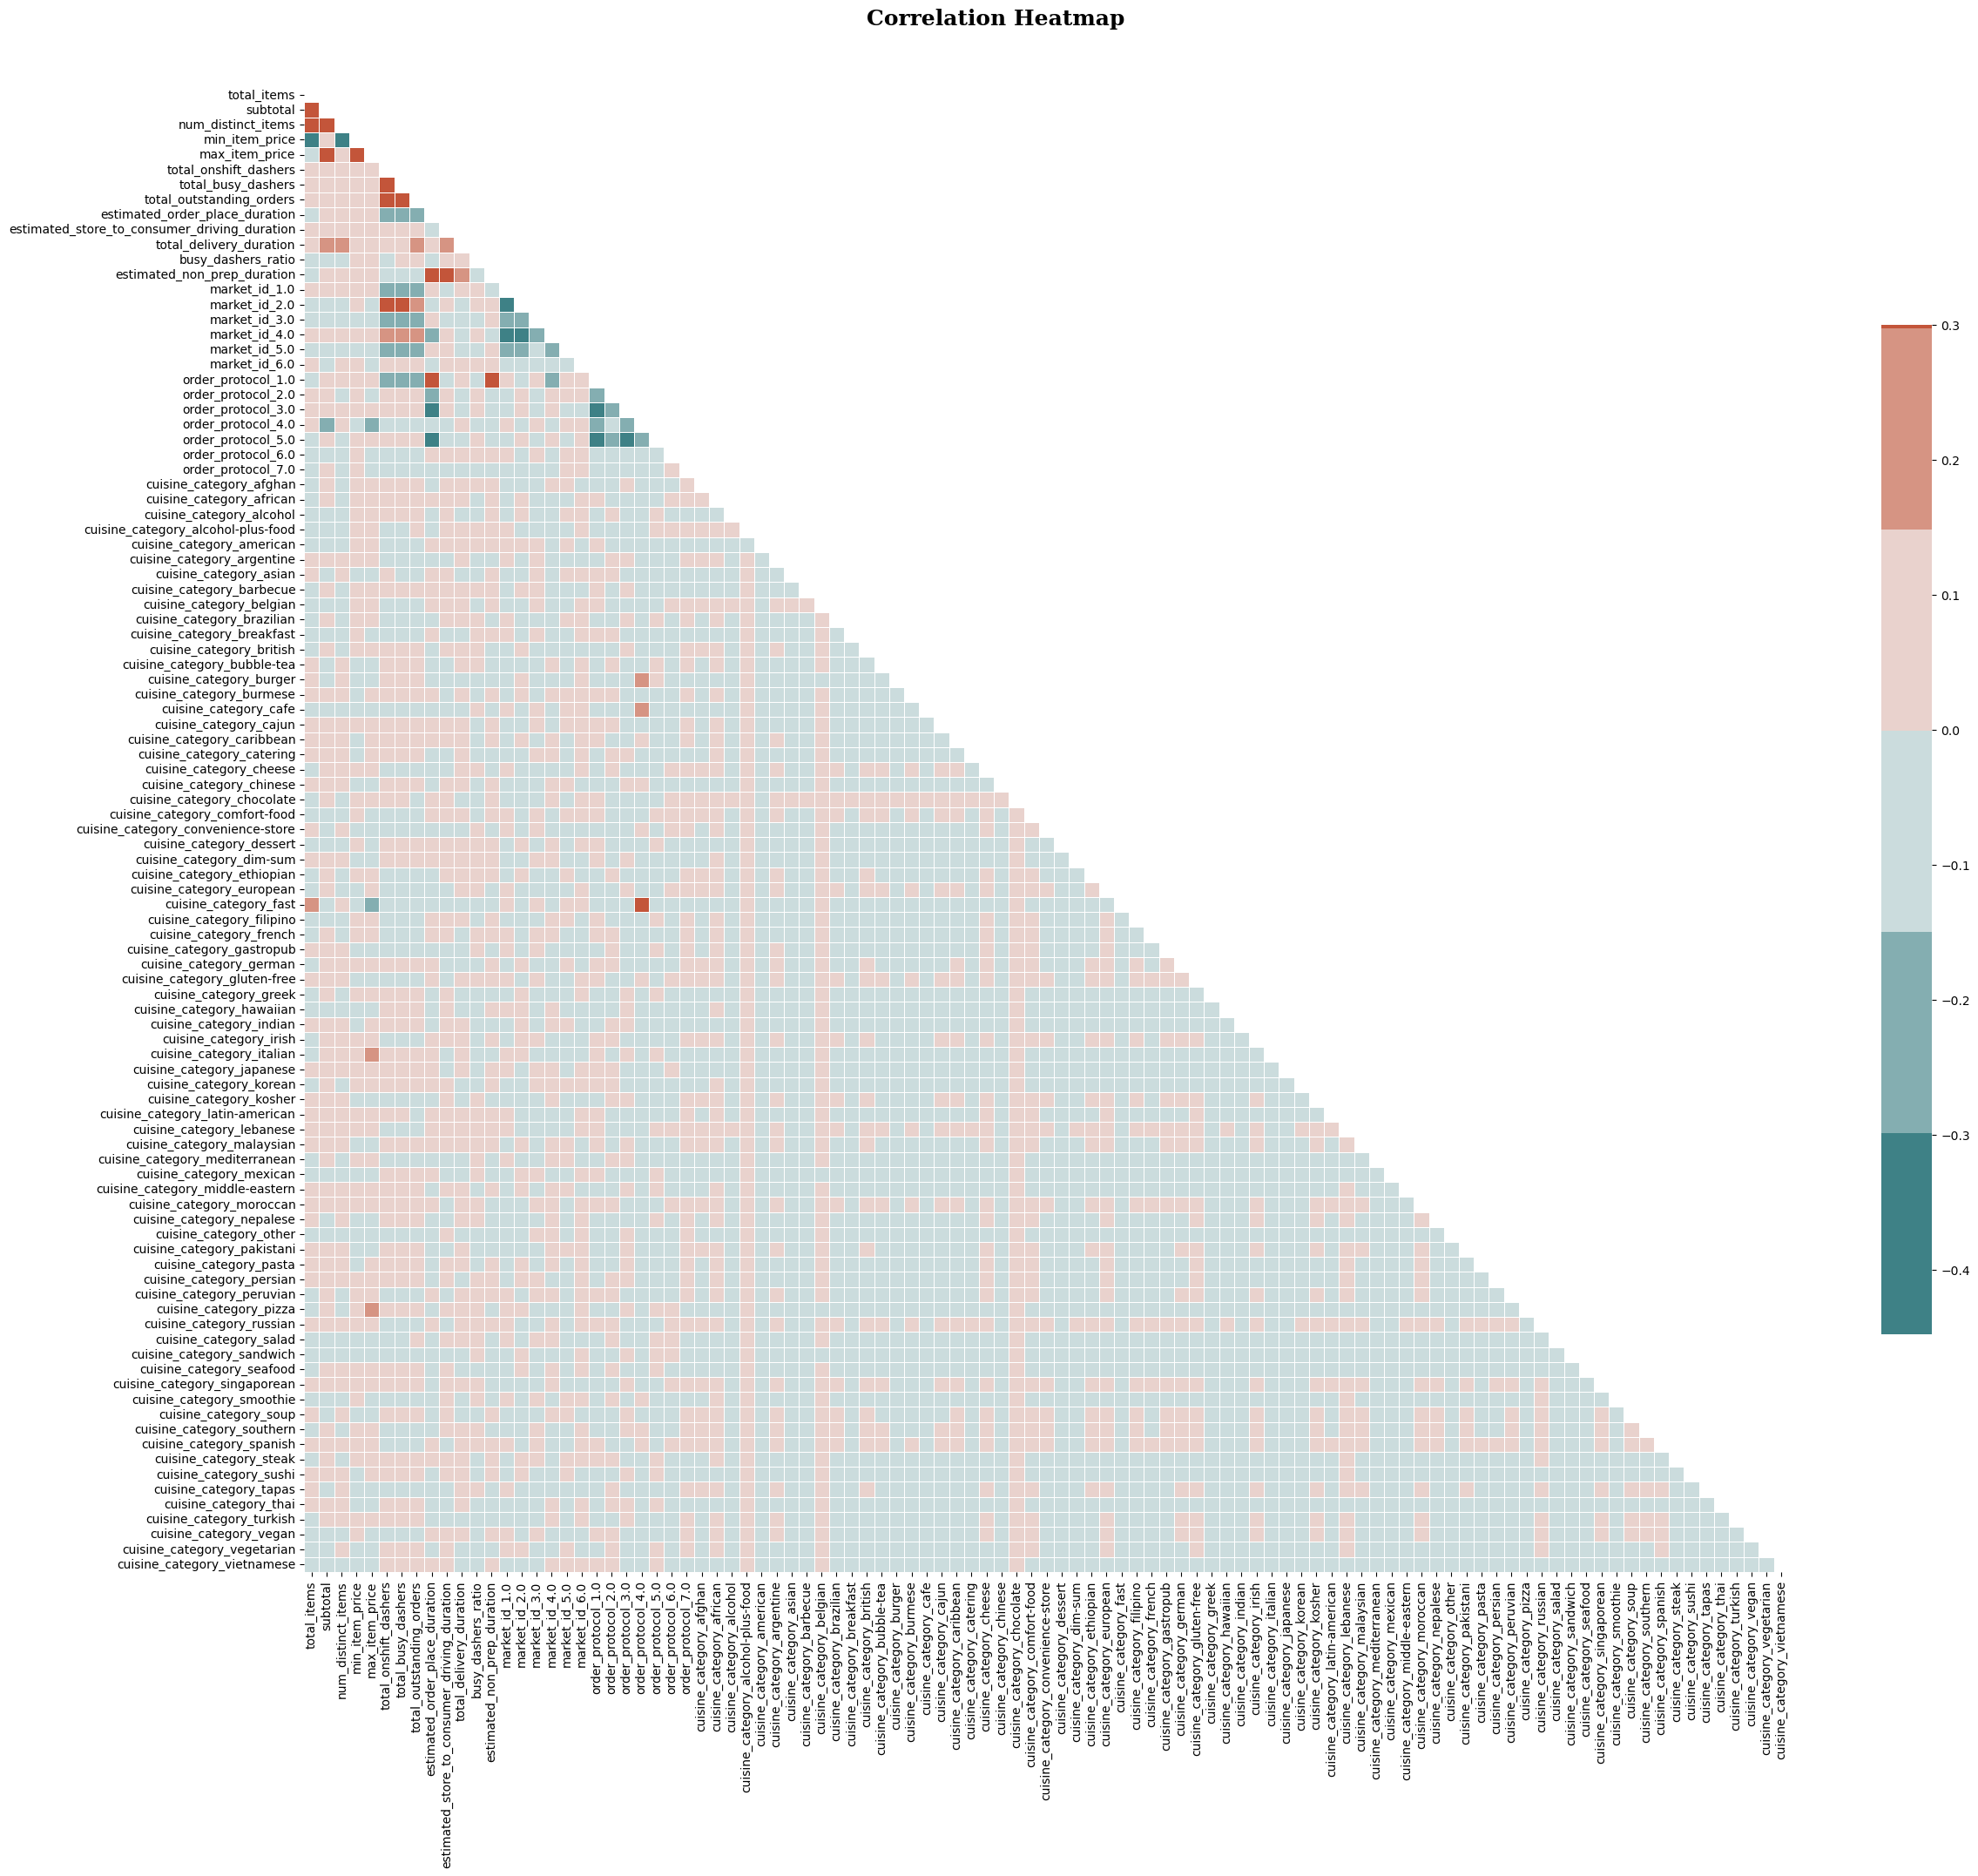

In [28]:
corr = train_df.corr()
correlation_heatmap(corr)

* Let's check the highest correlated features

In [29]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, n=20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941714
                                              total_outstanding_orders       0.934570
total_busy_dashers                            total_outstanding_orders       0.931192
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.924046
estimated_order_place_duration                order_protocol_1.0             0.901281
total_items                                   num_distinct_items             0.812675
subtotal                                      num_distinct_items             0.683364
total_items                                   subtotal                       0.597617
min_item_price                                max_item_price                 0.539786
subtotal                                      max_item_price                 0.509900
order_protocol_4.0                            cuisine_category_fast          0.499827
num_distinct_items          

* There are strong correlations in the features `total_onshift_dashers`, `total_busy_dashers`, and `estimated_non_prep_duration`. There is also correlation between the dummies `order_protocol` and `market_id`. Therefore, drop the dummies in the dataset.

In [30]:
df = df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'estimated_non_prep_duration'])
train_df = pd.concat([df, store_primary_category_dummies], axis=1)
train_df = train_df.astype('float32')
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,...,cuisine_category_southern,cuisine_category_spanish,cuisine_category_steak,cuisine_category_sushi,cuisine_category_tapas,cuisine_category_thai,cuisine_category_turkish,cuisine_category_vegan,cuisine_category_vegetarian,cuisine_category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,4771.0,3.0,820.0,1604.0,18.0,446.0,289.0,1586.0,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1525.0,1.0,1525.0,1525.0,8.0,446.0,795.0,2273.0,1.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,3620.0,2.0,1425.0,2195.0,7.0,446.0,205.0,2988.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, n=20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.812675
subtotal                                      num_distinct_items                0.683364
total_items                                   subtotal                          0.597617
min_item_price                                max_item_price                    0.539786
subtotal                                      max_item_price                    0.509900
num_distinct_items                            min_item_price                    0.447541
total_items                                   min_item_price                    0.417575
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.225878
subtotal                                      total_delivery_duration           0.206379
total_outstanding_orders                      total_delivery_duration           0.190484
total_items                                   cuisine_category_fast             0.17

* There are still correlations between `num_distinct_items`, `subtotal` and `total_items`. Let's create new features related to these features and then delete the highly correlated features from the dataset.

In [32]:
train_df['percent_distinct_item_of_total'] = train_df['num_distinct_items'] / train_df['total_items']
train_df['avg_price_per_item'] = train_df['subtotal'] / train_df['total_items']
train_df.drop(columns=['num_distinct_items', 'subtotal'], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, n=20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.862104
max_item_price                                avg_price_per_item                0.771568
min_item_price                                max_item_price                    0.539786
total_items                                   percent_distinct_item_of_total    0.473061
                                              min_item_price                    0.417575
                                              avg_price_per_item                0.332696
percent_distinct_item_of_total                avg_price_per_item                0.226607
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.225878
cuisine_category_pizza                        avg_price_per_item                0.218396
total_outstanding_orders                      total_delivery_duration           0.190484
max_item_price                                percent_distinct_item_of_total    0.17

* Now there are issues with `min_item_price` and `max_item_price`. Let's create a new feature by subtracting the minimum item price and the maximum item price.

In [33]:
train_df['price_range_of_items'] = train_df['max_item_price'] - train_df['min_item_price']
train_df.drop(columns=['min_item_price', 'max_item_price'], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, n=20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.473061
                                              price_range_of_items              0.358646
                                              avg_price_per_item                0.332696
percent_distinct_item_of_total                avg_price_per_item                0.226607
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.225878
cuisine_category_pizza                        avg_price_per_item                0.218396
total_outstanding_orders                      total_delivery_duration           0.190484
total_items                                   cuisine_category_fast             0.173084
total_outstanding_orders                      estimated_order_place_duration    0.173013
cuisine_category_fast                         avg_price_per_item                0.170783
cuisine_category_italian                      avg_price_per_item                0.15

In [34]:
train_df.shape

(171984, 82)

* We finally solved the correlation issue. Let's check Multicollinearity in the next step.

### Multicollinearity and Feature Selection<a id="5-4"></a>

* Let's check for multicollinearity with Variance Inflation Factor and then delete features with VIF score above 20.

In [35]:
feature = train_df.drop(columns=['total_delivery_duration']).columns.tolist()
vif_data = compute_vif(train_df, feature)
vif_data

,feature,VIF
0,cuisine_category_alcohol-plus-food,1.000509
1,cuisine_category_chocolate,1.000664
2,cuisine_category_belgian,1.001040
3,cuisine_category_lebanese,1.003956
4,cuisine_category_african,1.004912
...,...,...
76,cuisine_category_mexican,7.458254
77,cuisine_category_pizza,8.028947
78,cuisine_category_american,9.197788
79,estimated_order_place_duration,14.285278


In [36]:
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print('I will remove', highest_vif_feature)
    feature.remove(highest_vif_feature)
    vif_data = compute_vif(train_df, feature)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove percent_distinct_item_of_total


,feature,VIF
0,cuisine_category_alcohol-plus-food,1.000261
1,cuisine_category_chocolate,1.000426
2,cuisine_category_belgian,1.000539
3,cuisine_category_lebanese,1.002202
4,cuisine_category_russian,1.002596
...,...,...
75,cuisine_category_american,5.061055
76,avg_price_per_item,6.159860
77,busy_dashers_ratio,6.644463
78,estimated_store_to_consumer_driving_duration,7.328190


* Let's select feature to reduce dimension of the dataset and remove features that don't have a significant impact on the model. Way to do that is by using `PCA` and `Random Forest` regression method.

* Let's apply Random Forest Regression to our model and find the Genie's importance

In [37]:
# pd.concat([train_df[selected_features], train_df['total_delivery_duration']], axis=1).to_csv('../data/processed/df_after_feature_engineering.csv', index=False)

In [38]:
X = train_df[selected_features]
y = train_df['total_delivery_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

# Get feature importances and create a DataFrame
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Gini-Importance': forest.feature_importances_
})

importances = importances.sort_values(by='Gini-Importance', ascending=True)


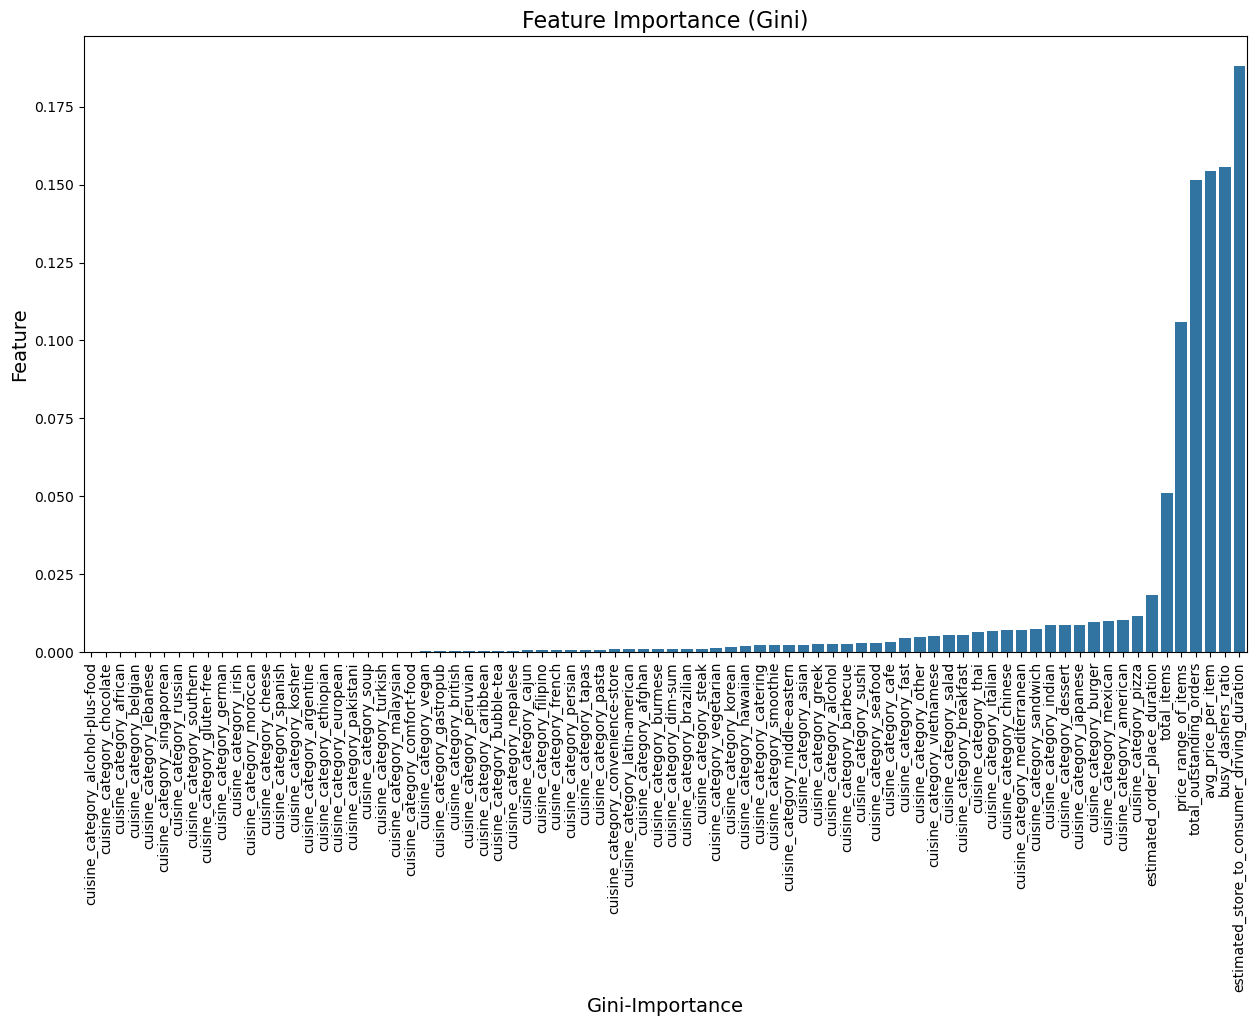

In [40]:
plot_gini_importance(importances)

## Build Machine Learning Models<a id ='6'></a>


<b> Model Selection Plan </b>

1. **Algorithms**
   - Test 5 different algorithms to find the best-performing model.

2. **Feature Set Sizes**
   - Use 4 feature set sizes:
     - Full feature set
     - Top 40 features (selected by Gini importance)
     - Top 20 features (selected by Gini importance)
     - Top 10 features (selected by Gini importance)

3. **Scalers**
   - Apply 3 different scalers:
     - Standard Scaler
     - Min-Max Scaler
     - No scaling (raw features)

In [41]:
# # RMSE function for inverse scaling
# def rmse_inverse(y_true, y_pred, y_scaler):
#     y_true_orig = y_scaler.inverse_transform(y_true.reshape(-1, 1))
#     y_pred_orig = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
#     return root_mean_squared_error(y_true_orig, y_pred_orig)

In [42]:
# # Regression function
# def create_regression(X, y, model, model_name, scaler_name, y_scaler=None, verbose=True):
#     """
#     Trains a regression model using cross-validation and computes RMSE.
#     Handles scaled and unscaled data correctly.

#     Args:
#     - X: Features (scaled or unscaled)
#     - y: Target variable (scaled or unscaled)
#     - model: Regression model to use
#     - model_name: Name of the model
#     - scaler_name: Name of the scaler used
#     - y_scaler: Target scaler for inverse scaling RMSE (if applicable)
#     - verbose: Whether to print detailed output

#     Returns:
#     - rmse_scores: List of RMSE scores across folds
#     - elapsed_time: Total time taken for cross-validation
#     """
#     start_time = time.time()
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)

#     if scaler_name != 'Without Scale' and y_scaler is not None:
#         rmse_scorer = make_scorer(lambda y_true, y_pred: rmse_inverse(y_true, y_pred, y_scaler), greater_is_better=False)
#     else:
#         rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
        
#     rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
#     end_time = time.time()
#     elapsed_time = end_time - start_time

#     if verbose:
#         print(f'Average RMSE : {-np.mean(rmse_scores):.4f} - Time taken: {elapsed_time:.4f} seconds')

#     return -np.mean(rmse_scores), round(elapsed_time, 4)

In [43]:
# # Scaling function
# def scale(scaler, X, y):
#     """
#     Scales features and target variable using the given scaler.

#     Args:
#     - scaler: Instance of sklearn scaler (e.g., MinMaxScaler, StandardScaler)
#     - X: Features
#     - y: Target variable

#     Returns:
#     - X_scaled: Scaled features
#     - y_scaled: Scaled target variable
#     - y_scaler: Scaler instance for the target variable
#     """
#     X_scaler = scaler
#     y_scaler = scaler

#     X_scaled = X_scaler.fit_transform(X)
#     y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
    
#     return X_scaled, y_scaled, y_scaler

In [44]:
# Data structures to store results
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
    "time_taken": []
}

# Regression models
regression_models = {
    "AdaBoost": AdaBoostRegressor(),
    "DecisionTree": DecisionTreeRegressor(max_depth=6),
    "GradientBoosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor()
}

# Feature sets
feature_sets = {
    "All Features": X.columns.to_list(),
    "Selected Features(40)": importances.sort_values(by='Gini-Importance')[-40:].Feature.tolist(),
    "Selected Features(20)": importances.sort_values(by='Gini-Importance')[-20:].Feature.tolist(),
    "Selected Features(10)": importances.sort_values(by='Gini-Importance')[-10:].Feature.tolist()
}

# Scalers
scalers = {
    "Standard Scaler": StandardScaler(),
    "Min-Max Scaler": MinMaxScaler(),
    "Without Scale": None
}

In [45]:
# Main loop for feature sets, scalers, and regression models
for feature_set_name, features in feature_sets.items():
    for scaler_name, scaler in scalers.items():
        for model_name, model in regression_models.items():
            print(f"Included Columns: {feature_set_name} | Scaling Method: {scaler_name} | Algorithm Used: {model_name}")

            X = train_df[features]
            y = train_df['total_delivery_duration']
            
            if model_name == "LGBM":
                model.set_params(force_col_wise=True)

            if scaler_name == 'Without Scale':
                avg_rmse_error, time_taken = create_regression(X, y, model, model_name, scaler_name, verbose=True)
            else:
                X_scaled, y_scaled, y_scaler = scale(scaler, X, y)
                avg_rmse_error, time_taken = create_regression(X_scaled, y_scaled[:, 0], model, model_name, scaler_name, y_scaler=y_scaler, verbose=True)

            print('-' * 100)

            # Store results in pred_dict
            pred_dict['regression_model'].append(model_name)
            pred_dict['feature_set'].append(feature_set_name)
            pred_dict['scaler_name'].append(scaler_name)
            pred_dict['RMSE'].append(avg_rmse_error)
            pred_dict['time_taken'].append(time_taken)

Included Columns: All Features | Scaling Method: Standard Scaler | Algorithm Used: AdaBoost
Average RMSE : 3410.5094 - Time taken: 70.4420 seconds
----------------------------------------------------------------------------------------------------
Included Columns: All Features | Scaling Method: Standard Scaler | Algorithm Used: DecisionTree
Average RMSE : 1076.4030 - Time taken: 3.3146 seconds
----------------------------------------------------------------------------------------------------
Included Columns: All Features | Scaling Method: Standard Scaler | Algorithm Used: GradientBoosting
Average RMSE : 1043.9842 - Time taken: 188.8759 seconds
----------------------------------------------------------------------------------------------------
Included Columns: All Features | Scaling Method: Standard Scaler | Algorithm Used: XGBoost
Average RMSE : 1044.2271 - Time taken: 7.2907 seconds
---------------------------------------------------------------------------------------------------

In [46]:
pd.DataFrame(data=pred_dict).sort_values(by='RMSE')

,regression_model,feature_set,scaler_name,RMSE,time_taken
4,LGBM,All Features,Standard Scaler,1037.222334,5.7852
19,LGBM,Selected Features(40),Standard Scaler,1037.477441,4.2657
14,LGBM,All Features,Without Scale,1037.628511,8.9861
9,LGBM,All Features,Min-Max Scaler,1037.755871,3.2360
24,LGBM,Selected Features(40),Min-Max Scaler,1037.767729,3.1504
29,LGBM,Selected Features(40),Without Scale,1037.862872,3.4437
34,LGBM,Selected Features(20),Standard Scaler,1039.109294,3.4571
39,LGBM,Selected Features(20),Min-Max Scaler,1039.161537,2.5919
44,LGBM,Selected Features(20),Without Scale,1039.344266,3.0129
49,LGBM,Selected Features(10),Standard Scaler,1041.476964,3.0871


In [49]:
pd.DataFrame(data=pred_dict).sort_values(by='RMSE').to_excel('../data/processed/ml_result.xlsx', index=False)